<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [1]:
student_number = '99100455'
first_name = 'Danial'
last_name = 'Ataee'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import cvxopt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
import copy

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable. 

In [3]:
data = pd.read_csv('./Data/satimage.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,label
0,7.5,6.272730,4.047619,3.975208,3.032258,4.545455,8.421050,1.8125,-2.2500,0.077672,...,-0.600000,-0.138462,-0.188119,-0.431579,-0.546875,-0.15625,-0.126214,-0.431579,-0.484375,6.0
1,7.5,4.090909,-0.714290,1.776858,2.903226,3.090909,5.052630,-1.7500,-2.2500,0.077672,...,-0.600000,-0.015385,-0.049505,-0.431579,-0.609375,-0.15625,-0.126214,-0.494737,-0.609375,6.0
2,12.0,9.909090,8.333330,5.479339,3.354839,7.272730,10.526316,2.7500,3.4375,6.368924,...,-0.233333,0.200000,0.207921,-0.010526,-0.312500,-0.15625,0.009709,-0.326316,-0.437500,6.0
3,7.5,4.818182,1.190480,2.702482,2.774194,2.363640,5.894740,-0.2500,-3.8750,-2.368924,...,-0.383333,-0.138462,-0.049505,-0.347368,-0.484375,0.09375,0.087379,-0.031579,-0.218750,6.0
4,7.5,4.818182,2.142860,2.702482,3.032258,3.090909,6.736840,-1.0000,-0.6250,-1.320388,...,-0.183333,0.230769,0.267327,-0.031579,-0.281250,-0.03125,-0.126214,-0.431579,-0.546875,6.0


In [4]:
data['label'].unique()

array([6., 2., 1., 5., 3., 4.])

Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [5]:
data = data[(data['label'] == 4) | (data['label'] == 6)]

X = data.drop(['label'], axis=1).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.625)

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [7]:
y_train = np.where(y_train == 4, 1, -1)
y_val = np.where(y_val == 4, 1, -1)
y_test = np.where(y_test == 4, 1, -1)

# Model (50 points)

Here is soft margin svm convex optimization formulation. 
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

$$
\text{Maximize}\ \ \sum_{n=1}^{N}\alpha_n-\frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N}
\alpha_n\alpha_my^{(n)}y^{(m)}x^{{(n)}^T}x^{(m)}
$$
$$
\text{s.t.}
\begin{cases}
    \sum\limits_{n=1}^{N}\alpha_ny^{(n)}=0 \\
    0\leq\alpha_n\leq C & n=1,\dots,N
\end{cases}
$$

Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [8]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """

    n_samples, n_features = X.shape

    # Gram matrix
    K = np.dot(X, X.T)

    # P, q, G, h, A, b matrices for cvxopt
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n_samples))
    G = cvxopt.matrix(np.vstack((np.eye(n_samples) * -1, np.eye(n_samples))))
    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = cvxopt.matrix(y, (1, n_samples), 'd')
    b = cvxopt.matrix(0.0)

    # Solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    alphas = np.array(solution['x']).flatten()

    # Support vectors have non-zero lagrange multipliers
    sv = (alphas > 1e-5)
    ind = np.arange(len(alphas))[sv]
    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [9]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C)

     pcost       dcost       gap    pres   dres
 0: -6.1347e+02 -3.3324e+03  2e+04  3e+00  4e-13
 1: -4.2280e+02 -2.2442e+03  3e+03  4e-01  2e-13
 2: -3.9327e+02 -8.2039e+02  5e+02  4e-02  2e-13
 3: -4.3173e+02 -5.6725e+02  2e+02  1e-02  2e-13
 4: -4.5093e+02 -5.2320e+02  8e+01  5e-03  2e-13
 5: -4.5957e+02 -5.0423e+02  5e+01  2e-03  2e-13
 6: -4.6654e+02 -4.9024e+02  2e+01  1e-03  2e-13
 7: -4.7068e+02 -4.8224e+02  1e+01  3e-04  2e-13
 8: -4.7349e+02 -4.7802e+02  5e+00  1e-04  2e-13
 9: -4.7454e+02 -4.7643e+02  2e+00  4e-05  2e-13
10: -4.7502e+02 -4.7573e+02  7e-01  1e-05  2e-13
11: -4.7528e+02 -4.7540e+02  1e-01  1e-06  2e-13
12: -4.7533e+02 -4.7534e+02  8e-03  8e-08  2e-13
13: -4.7533e+02 -4.7534e+02  1e-04  1e-09  2e-13
Optimal solution found.


In [10]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    output:
        y_pred: predictoin labels
    """
    
    K = np.dot(support_vectors, x_test.T)
    decision_func = np.dot((support_vector_labels * support_vector_alphas).reshape(1, -1), K)
    y_pred = np.sign(decision_func).flatten()
    return y_pred

In [11]:
y_pred = predict_labels(np.array(X_test), support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [12]:
def evaluate(y_test, y_pred):
    """
    input:
        y_test: true labels
        y_pred: predicted labels
    output:
        accuracy: accuracy of the model
        balanced_accuracy: balanced accuracy of the model
        confusion_matrix: confusion matrix of the model
    """
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    
    return accuracy, balanced_accuracy, confusion_mat

_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.7883895131086143
Balanced Accuracy:  0.8292613636363637
Confusion Matrix:
 [[272 102]
 [ 11 149]]


<Axes: >

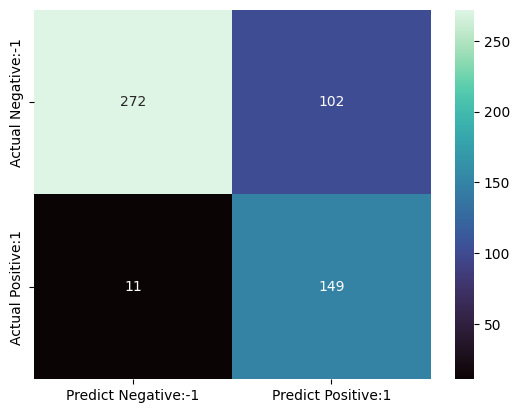

In [13]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [14]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    diff = np.subtract(x1, x2)
    squared_norm = np.dot(diff, diff)
    return np.exp(-gamma * squared_norm)

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """

    n = X.shape[0]
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = rbf(X[i], X[j], gamma)
    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-np.ones(n))
    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros(n), C * np.ones(n))))
    A = cvxopt.matrix(y, (1, n), 'd')
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    sv = (alphas > 1e-5)
    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [15]:
gammas = [00.1, 0.1, 1, 10, 100]
best_gamma = None
best_balanced_accuracy = -1
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

for gamma in gammas:
    print("solving for gamma={}:\n".format(gamma))
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C, gamma)
    y_pred = predict_labels(np.array(X_val), support_vectors, support_vector_labels, support_vector_alphas)
    _, ba, _ = evaluate(y_val, y_pred)
    print()
    if ba > best_balanced_accuracy:
        best_gamma = gamma
        best_balanced_accuracy = ba
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas

print(best_gamma)

solving for gamma=0.1:

     pcost       dcost       gap    pres   dres
 0: -2.3534e+02 -2.5450e+03  1e+04  2e+00  1e-15
 1: -1.9153e+02 -1.4528e+03  2e+03  1e-01  1e-15
 2: -2.0922e+02 -4.4909e+02  3e+02  2e-02  1e-15
 3: -2.3314e+02 -3.0204e+02  7e+01  4e-03  1e-15
 4: -2.4426e+02 -2.5935e+02  2e+01  1e-04  1e-15
 5: -2.4679e+02 -2.5164e+02  5e+00  2e-05  1e-15
 6: -2.4746e+02 -2.4986e+02  2e+00  9e-06  1e-15
 7: -2.4781e+02 -2.4895e+02  1e+00  1e-14  1e-15
 8: -2.4808e+02 -2.4832e+02  2e-01  2e-14  1e-15
 9: -2.4814e+02 -2.4820e+02  6e-02  3e-15  1e-15
10: -2.4816e+02 -2.4816e+02  3e-03  1e-14  1e-15
11: -2.4816e+02 -2.4816e+02  4e-05  1e-14  1e-15
Optimal solution found.
Accuracy:  0.803125
Balanced Accuracy:  0.8421912746909195
Confusion Matrix:
 [[170  57]
 [  6  87]]

solving for gamma=0.1:

     pcost       dcost       gap    pres   dres
 0: -2.3534e+02 -2.5450e+03  1e+04  2e+00  1e-15
 1: -1.9153e+02 -1.4528e+03  2e+03  1e-01  1e-15
 2: -2.0922e+02 -4.4909e+02  3e+02  2e-02  1

In [16]:
y_pred = predict_labels(np.array(X_test), best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.7902621722846442
Balanced Accuracy:  0.8323863636363636
Confusion Matrix:
 [[272 102]
 [ 10 150]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [17]:
data = pd.read_csv('./Data/satimage.csv')

X = data.drop(['label'], axis=1).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.625)

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [18]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    confusion_mat = confusion_matrix(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Balanced Accuracy:", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    return accuracy, balanced_accuracy, confusion_mat

# Create the parameter grid
param_grid = {'C': Cs, 'gamma': gammas}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')

# Train the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

# Print the best hyperparameters
print("Best C:", best_C)
print("Best Gamma:", best_gamma)

# Predict labels on test data using the model with best hyperparameters
y_pred = grid_search.predict(X_test)

# Evaluate the model
evaluate(y_test, y_pred)

Best C: 10
Best Gamma: 0.1
Accuracy: 0.9179614667495338
Balanced Accuracy: 0.8925105909690897
Confusion Matrix:
 [[391   0   5   0   0   0]
 [  0 167   0   0   1   0]
 [  2   1 313  10   0   4]
 [  0   2  38  88   2  27]
 [  2   1   0   0 166   7]
 [  0   0   8  15   7 352]]


(0.9179614667495338,
 0.8925105909690897,
 array([[391,   0,   5,   0,   0,   0],
        [  0, 167,   0,   0,   1,   0],
        [  2,   1, 313,  10,   0,   4],
        [  0,   2,  38,  88,   2,  27],
        [  2,   1,   0,   0, 166,   7],
        [  0,   0,   8,  15,   7, 352]], dtype=int64))

Implement Multiclass SVM from scratch without using ready functions (optional).

In [19]:
class SVM:
    linear = lambda x, x_ , c=0: x @ x_ .T
    polynomial = lambda x, x_ , Q=5: (1 + x @ x_.T)**Q
    rbf = lambda x, x_ , gamma=10: np.exp(-gamma * distance.cdist(x, x_,'sqeuclidean'))
    kernel_funs = {'linear': linear, 'polynomial': polynomial, 'rbf': rbf}
    
    def __init__(self, kernel='rbf', C=1, k=2):
        # set the hyperparameters
        self.kernel_str = kernel
        self.kernel = SVM.kernel_funs[kernel]
        self.C = C                  # regularization parameter
        self.k = k                  # kernel parameter
        
        # training data and support vectors
        self.X, y = None, None
        self.alphas = None
        
        # for multi-class classification
        self.multiclass = False
        self.clfs = []                                  

    def fit(self, X, y):
        if len(np.unique(y)) > 2:
            self.multiclass = True
            return self.multi_fit(X, y)
        
        # relabel if needed
        if set(np.unique(y)) == {0, 1}: y[y == 0] = -1
        # ensure y has dimensions Nx1
        self.y = y.reshape(-1, 1).astype(np.double) # Has to be a column vector
        self.X = X
        N = X.shape[0]
        
        # compute the kernel over all possible pairs of (x, x') in the data
        self.K = self.kernel(X, X, self.k)
        
        # For 1/2 x^T P x + q^T x
        P = cvxopt.matrix(self.y @ self.y.T * self.K)
        q = cvxopt.matrix(-np.ones((N, 1)))
        
        # For Ax = b
        A = cvxopt.matrix(self.y.T)
        b = cvxopt.matrix(np.zeros(1))

        # For Gx <= h
        G = cvxopt.matrix(np.vstack((-np.identity(N),
                                    np.identity(N))))
        h = cvxopt.matrix(np.vstack((np.zeros((N,1)),
                                    np.ones((N,1)) * self.C)))

        # Solve    
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])
            
        # Maps into support vectors
        self.is_sv = ((self.alphas > 1e-3) & (self.alphas <= self.C)).squeeze()
        self.margin_sv = np.argmax((1e-3 < self.alphas) & (self.alphas < self.C - 1e-3))

    def multi_fit(self, X, y):
        self.k = len(np.unique(y))      # number of classes
        # for each pair of classes
        for i in range(self.k):
            # get the data for the pair
            Xs, Ys = X, copy.copy(y)
            # change the labels to -1 and 1
            Ys[Ys!=i], Ys[Ys==i] = -1, +1
            # fit the classifier
            clf = SVM(kernel=self.kernel_str, C=self.C, k=self.k)
            clf.fit(Xs, Ys)
            # save the classifier
            self.clfs.append(clf)

    def predict(self, X_t):
        if self.multiclass: return self.multi_predict(X_t)
        xₛ, yₛ = self.X[self.margin_sv, np.newaxis], self.y[self.margin_sv]
        alphas, y, X= self.alphas[self.is_sv], self.y[self.is_sv], self.X[self.is_sv]

        b = yₛ - np.sum(alphas * y * self.kernel(X, xₛ, self.k), axis=0)
        score = np.sum(alphas * y * self.kernel(X, X_t, self.k), axis=0) + b
        return np.sign(score).astype(int), score

    def multi_predict(self, X):
        # get the predictions from all classifiers
        preds = np.zeros((X.shape[0], self.k))
        for i, clf in enumerate(self.clfs):
            _, preds[:, i] = clf.predict(X)
        
        # get the argmax and the corresponding score
        return np.argmax(preds, axis=1)

    def evaluate(self, X,y):  
        outputs, _ = self.predict(X)
        accuracy = np.sum(outputs == y) / len(y)
        return round(accuracy, 2)

In [29]:
my_svm = SVM(k=6)
my_svm.fit(X_train, y_train)
y_pred = my_svm.multi_predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.8614045991298943
Balanced Accuracy: 0.8172144215635978
Confusion Matrix:
 [[391   0   3   0   2   0]
 [  0 161   0   0   7   0]
 [  1   0 309  18   1   1]
 [  1   2  44  54   5  51]
 [  6  10   0   1 145  14]
 [  0   0  11  31  14 326]]


# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

In [22]:
C = 10

svc_linear = SVC(kernel='linear', C=C)
svc_linear.fit(X_train, y_train)
y_pred = svc_linear.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy: 0.8551895587321318
Balanced Accuracy: 0.8094841942932366
Confusion Matrix:
 [[390   0   4   0   2   0]
 [  1 158   0   1   8   0]
 [  2   0 308  19   0   1]
 [  1   2  43  53   5  53]
 [  8   9   0   1 143  15]
 [  0   0  10  32  16 324]]


### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part. 

In [24]:
svc_rbf = SVC(kernel='rbf', C=C, gamma=0.1)
svc_rbf.fit(X_train, y_train)
y_pred = svc_rbf.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy: 0.9179614667495338
Balanced Accuracy: 0.8925105909690897
Confusion Matrix:
 [[391   0   5   0   0   0]
 [  0 167   0   0   1   0]
 [  2   1 313  10   0   4]
 [  0   2  38  88   2  27]
 [  2   1   0   0 166   7]
 [  0   0   8  15   7 352]]


### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

In [25]:
svc_poly = SVC(kernel='poly', C=C, degree=6, coef0=1)
svc_poly.fit(X_train, y_train)
y_pred = svc_poly.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy: 0.9049098819142325
Balanced Accuracy: 0.8827016843582355
Confusion Matrix:
 [[391   0   4   0   1   0]
 [  0 165   0   0   3   0]
 [  5   0 304  12   0   9]
 [  1   3  31  93   2  27]
 [  2   2   0   1 162   9]
 [  0   1   9  21  10 341]]


### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts. 

In [26]:
svc_sigmoid = SVC(kernel='sigmoid', C=C, gamma=1, coef0=0)
svc_sigmoid.fit(X_train, y_train)
y_pred = svc_sigmoid.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy: 0.48788067122436296
Balanced Accuracy: 0.3882636994429188
Confusion Matrix:
 [[294  42  47  13   0   0]
 [134  27   4   0   2   1]
 [ 48   0 268   7   3   4]
 [  2   0 102  18   3  32]
 [ 43  46   6  35  11  35]
 [  2   0  42 154  17 167]]


Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one? 

# Model Performance Analysis

After tuning the models, we can compare their performance by their accuracy and balanced accuracy. Linear, polynomial, and RBF kernels had the highest accuracy/balanced accuracy (88% in average) with very close results, with RBF having the best performance. Sigmoid operated significantly poorer than the other three with extremely low accuracy (~50%) and balanced accuracy (~40%).

## Comparing Kernels

### Linear Kernel:

**Characteristics:**
- The linear kernel is the simplest form of kernel function used in SVM.
- It computes the dot product between two feature vectors.
- Decision boundary is a straight line in the input space.

**Performance:**
- Linear kernels work well when the data is linearly separable.
- They are computationally efficient and fast to train.
- They perform best when the relationship between features and labels is close to linear.

**Suitability:**
- Suitable for datasets with a large number of features and a linear relationship between features and labels.
- Effective when the decision boundary is expected to be close to linear.

### RBF (Radial Basis Function) Kernel:

**Characteristics:**
- The RBF kernel computes the similarity between two feature vectors based on the Gaussian (or Radial Basis) function.
- It is capable of capturing complex, nonlinear relationships in the data.
- Decision boundary is non-linear and can adapt to the shape of the data.

**Performance:**
- RBF kernels are highly flexible and can model complex decision boundaries.
- They perform well on datasets with non-linear relationships and are suitable for high-dimensional data.
- However, they are more prone to overfitting and require careful tuning of hyperparameters.

**Suitability:**
- Suitable for datasets with complex and non-linear relationships.
- Effective when the decision boundary is expected to be non-linear and adaptive to the data distribution.

### Polynomial Kernel:

**Characteristics:**
- The polynomial kernel computes the similarity between two feature vectors using polynomial functions.
- It can learn decision boundaries of various shapes by setting higher polynomial degrees.
- Decision boundary can have different degrees depending on the polynomial degree.

**Performance:**
- Polynomial kernels can capture non-linear relationships in the data.
- They perform well when the decision boundary has a polynomial shape.
- However, they are sensitive to the choice of hyperparameters and can be computationally expensive, especially for higher polynomial degrees.

**Suitability:**
- Suitable for datasets with non-linear relationships where the decision boundary has a polynomial shape.
- Effective when the relationship between features and labels can be represented by polynomial functions.

### Sigmoid Kernel:

**Characteristics:**
- The sigmoid kernel computes the similarity between two feature vectors using sigmoid functions.
- It can capture non-linear relationships and is useful for binary classification tasks.
- Decision boundary is shaped by the sigmoid function.

**Performance:**
- Sigmoid kernels can capture non-linear relationships, but they often perform poorly compared to other kernels.
- They are less common in practice due to their limited applicability and tendency to underperform.
- Sensitive to the choice of hyperparameters and may require careful tuning.

**Suitability:**
- Suitable for binary classification tasks with non-linearly separable data.
- Effective when dealing with non-linear relationships and when the decision boundary can be shaped by sigmoid functions.